In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import matplotlib.pyplot as plt

In [57]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [58]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [59]:
# output y_train has one extra channel. Removing it.
y_train = y_train.squeeze()
y_test  = y_test.squeeze()


In [60]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

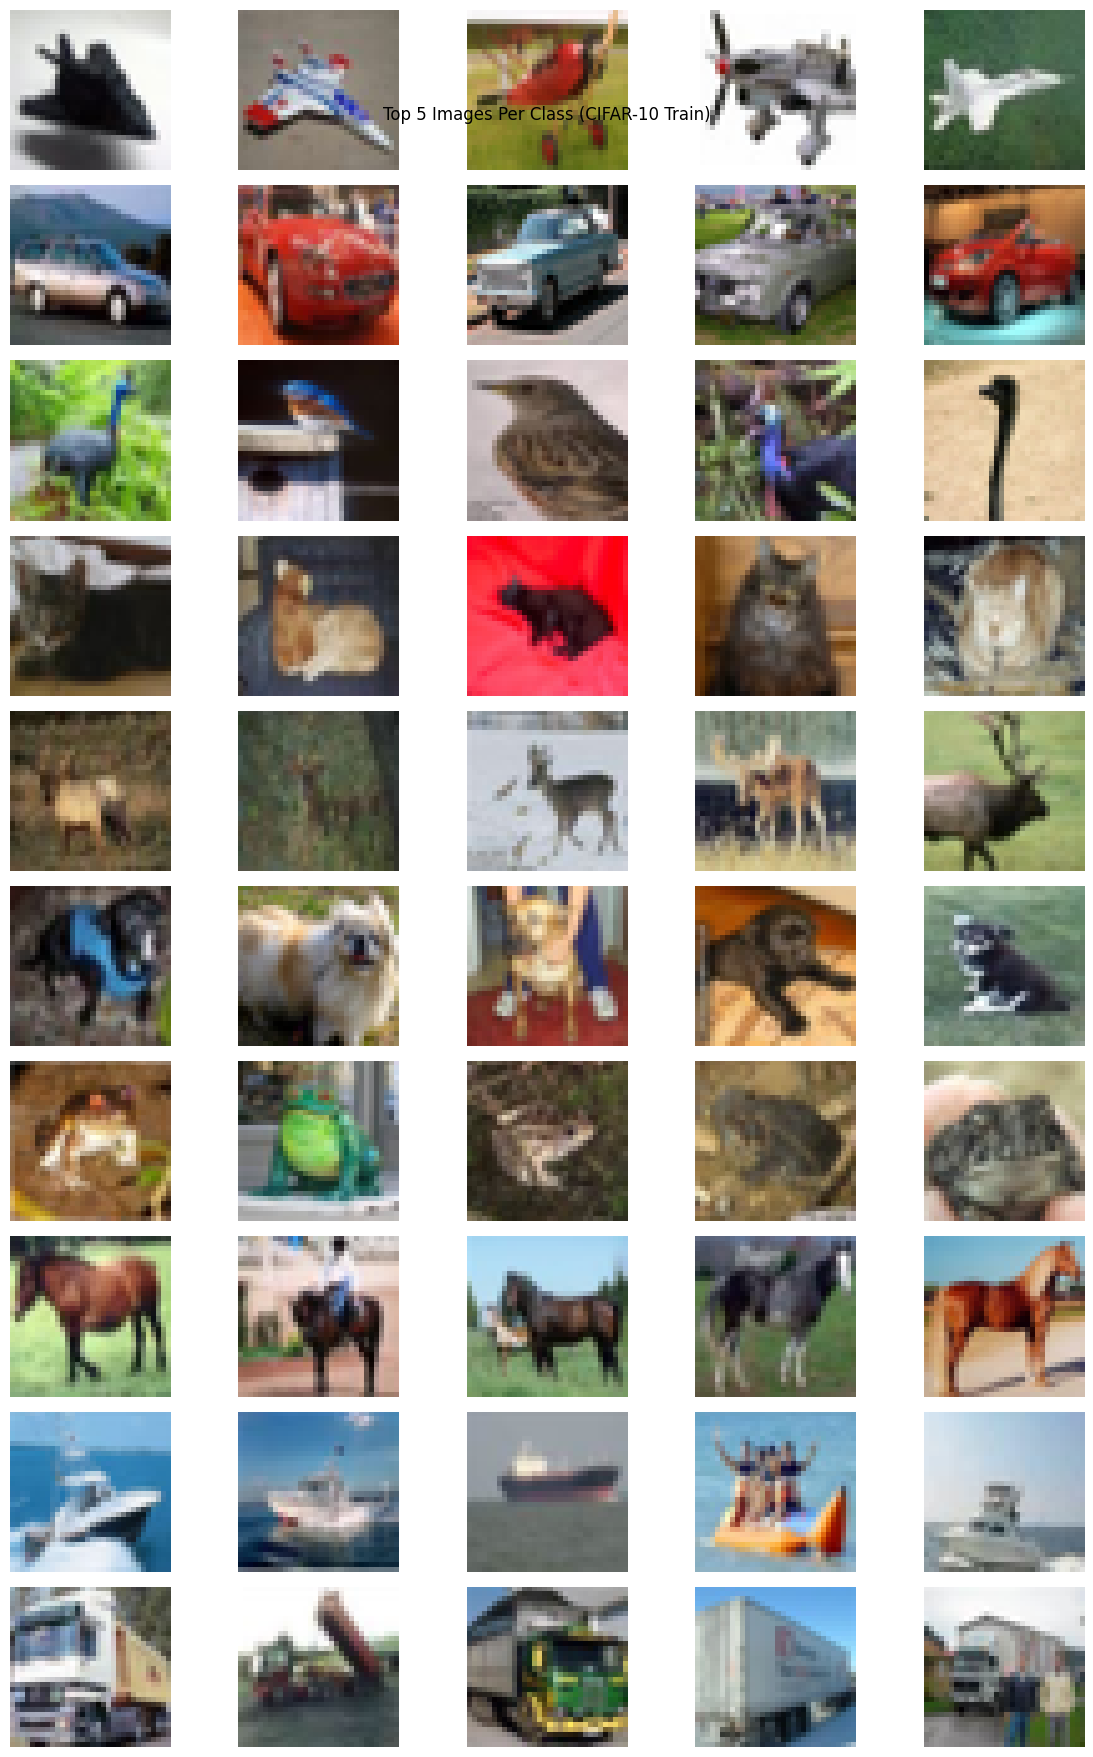

In [61]:
plt.figure(figsize=(12, 18))
for c in range(10):
    idx = np.where(y_train == c)[0][:5]
    for j, i in enumerate(idx):
        plt.subplot(10, 5, c * 5 + j + 1)
        plt.imshow(X_train[i])
        if j == 0:
            plt.ylabel(f"{c}: {class_names[c]}", rotation=0, labelpad=50, fontsize=10)
        plt.axis("off")

plt.suptitle("Top 5 Images Per Class (CIFAR-10 Train)", y=0.92)
plt.tight_layout()
plt.show()

In [62]:
# Preprocess
X_train = (X_train.astype('float32') / 255.0)
X_test = (X_test.astype('float32') / 255.0)

In [63]:
mean = X_train.mean(axis=(0,1,2), keepdims=True)
std  = X_train.std(axis=(0,1,2), keepdims=True) + 1e-7

x_train = (X_train - mean) / std
x_test  = (X_test  - mean) / std

In [64]:
# Shuffle before val split (fixed seed)
rng = np.random.default_rng(42)
idx = rng.permutation(len(X_train))

X_train, y_train = X_train[idx], y_train[idx]

In [65]:
val_size = 5000
X_val, y_val = X_train[:5000], y_train[:5000]
X_tr, y_tr = X_train[5000:], y_train[5000:]


In [66]:
wd = keras.regularizers.l2(1e-4)
model = keras.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    layers.RandomFlip('horizontal'),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.10),

    # Block 1
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(32, 3, padding='same', kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.MaxPooling2D(),
    layers.Dropout(0.20),

    # Block 2
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(32, 3, padding='same', kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    # Block 3
    layers.Conv2D(32, 3, padding='same', kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(32, 3, padding='same', kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.40),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, kernel_regularizer=wd),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.40),

    layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_6 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_6            │ (None, 32, 32, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8, 8, 32)       │           12

 Total params: 53,930 (210.66 KB)

 Trainable params: 53,290 (208.16 KB)

 Non-trainable params: 640 (2.50 KB)

In [83]:
batch_size = 128
steps_per_epoch = len(X_tr) // batch_size

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=steps_per_epoch * 100
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "cifar10_best.keras", monitor="val_accuracy",
        save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=15,
        restore_best_weights=True, verbose=1
    ),
]


history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)



history = model.fit(X_tr, y_tr, 
            validation_data=(X_val, y_val),
            epochs=40,
            batch_size=128,
            callbacks=callbacks,
            verbose=1)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4162 - loss: 1.6817
Epoch 1: val_accuracy improved from None to 0.42700, saving model to cifar10_best.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 30s 68ms/step - accuracy: 0.4744 - loss: 1.5076 - val_accuracy: 0.4270 - val_loss: 1.9569
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5610 - loss: 1.2879
Epoch 2: val_accuracy did not improve from 0.42700
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.5690 - loss: 1.2718 - val_accuracy: 0.4234 - val_loss: 2.2123
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5899 - loss: 1.2357
Epoch 3: val_accuracy improved from 0.42700 to 0.51600, saving model to cifar10_best.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.5963 - loss: 1.2192 - val_accuracy: 0.5160 - val_loss: 1.5466
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6101 - loss: 1.1931
Epoch 4: val_accuracy did not improve from 0.51600
352/352 ━━

In [84]:
# --------------------
# 7) Evaluate best saved model
# --------------------
best = keras.models.load_model("cifar10_best.keras")
test_loss, test_acc = best.evaluate(X_test, y_test, verbose=1)
print("Best model Test Accuracy =", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7833 - loss: 0.7327
Best model Test Accuracy = 0.78329998254776


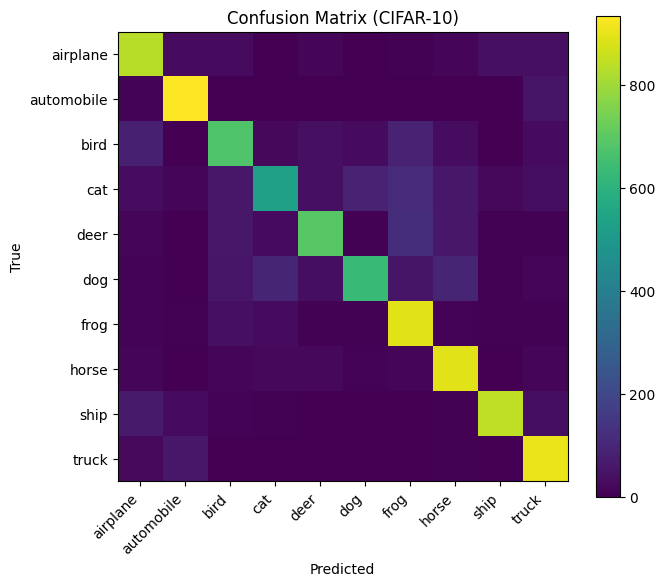

In [85]:
# --------------------
# 8) Confusion matrix + Top 10 confusions
# --------------------
probs = best.predict(X_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

cm = tf.math.confusion_matrix(y_test, y_pred, num_classes=10).numpy()

plt.figure(figsize=(7, 6))
plt.imshow(cm)
plt.title("Confusion Matrix (CIFAR-10)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.yticks(range(10), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


In [86]:
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)
pairs = np.dstack(np.unravel_index(np.argsort(cm_off.ravel())[::-1], cm_off.shape))[0]

print("\nTop confusions (true -> pred : count)")
for i in range(10):
    t, p = pairs[i]
    print(f"{t}({class_names[t]}) -> {p}({class_names[p]}) : {cm[t, p]}")


Top confusions (true -> pred : count)
4(deer) -> 6(frog) : 121
3(cat) -> 6(frog) : 116
5(dog) -> 3(cat) : 98
5(dog) -> 7(horse) : 97
2(bird) -> 6(frog) : 92
3(cat) -> 5(dog) : 89
2(bird) -> 0(airplane) : 82
8(ship) -> 0(airplane) : 68
4(deer) -> 2(bird) : 62
4(deer) -> 7(horse) : 62


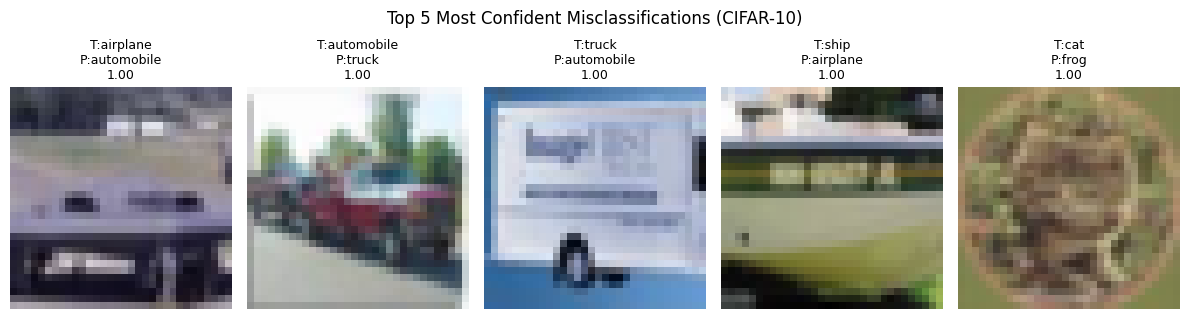

In [88]:
y_test_1d = np.squeeze(y_test)   # (N,)
y_pred_1d = np.squeeze(y_pred)   # (N,)

wrong_idx = np.where(y_pred_1d != y_test_1d)[0]
wrong_conf = probs[wrong_idx, y_pred_1d[wrong_idx]]
top_wrong = wrong_idx[np.argsort(wrong_conf)[::-1]][:5]

plt.figure(figsize=(12, 3))
for k, idx in enumerate(top_wrong):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[idx])

    true_name = class_names[int(y_test_1d[idx])]
    pred_name = class_names[int(y_pred_1d[idx])]
    conf = probs[idx, int(y_pred_1d[idx])]

    plt.title(f"T:{true_name}\nP:{pred_name}\n{conf:.2f}", fontsize=9)
    plt.axis("off")

plt.suptitle("Top 5 Most Confident Misclassifications (CIFAR-10)", y=1.05)
plt.tight_layout()
plt.show()